# Text Preprocessing

In [79]:
# 1
import pandas as pd
import yaml
import os
import pathlib

ROOT = pathlib.Path().resolve().parent.parent

with open(ROOT / "config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

DATA_PATH = ROOT / config['api']['DATA_PATH']

In [80]:
# 2

comments = pd.read_excel(DATA_PATH / 'comment' / 'Parent_Comments_UNION.xlsx')

In [81]:
# 3
comments = comments.dropna(subset=['snippet.textOriginal'])

In [82]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74949 entries, 0 to 74962
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   kind                           74949 non-null  object 
 1   etag                           74949 non-null  object 
 2   id                             74949 non-null  object 
 3   snippet.videoId                74949 non-null  object 
 4   snippet.textDisplay            74949 non-null  object 
 5   snippet.textOriginal           74949 non-null  object 
 6   snippet.authorDisplayName      74939 non-null  object 
 7   snippet.authorProfileImageUrl  74949 non-null  object 
 8   snippet.authorChannelUrl       74943 non-null  object 
 9   snippet.authorChannelId.value  74943 non-null  object 
 10  snippet.canRate                74949 non-null  bool   
 11  snippet.viewerRating           74949 non-null  object 
 12  snippet.likeCount              74949 non-null 

# Текст процессинг

In [93]:
corpora = list(comments['snippet.textOriginal'].values)

In [94]:
# download stopwords corpus, you need to run it once
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation


#Create lemmatizer and stopwords list
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

", ".join(russian_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, почти, мой, тем, чтобы, нее, сейчас, были, куда, зачем, всех, никогда, можно, при, наконец, два, об, другой, хоть, после, над, больше, тот, через, эти, нас, про, всего, них, какая, много, разве, три, эту, моя, впрочем, хорошо, свою, этой, перед, иногда, лучше, чуть, том, нельзя, такой, им, более, всегда, конечно, всю, между'

In [95]:
#Preprocess functions
import string
import re

PUNCT_TO_REMOVE = string.punctuation

def remove_tabs(text): #убираем дичь со специальными символами
    return text.translate(str.maketrans("\n\t\r", "   "))

def remove_punct(text):
    return re.sub(r'[^a-zA-Zа-яА-ЯёЁ]+',' ', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)

def remove_hashtags(text):
    return re.sub("#[A-Za-z0-9_]+","", text)


def preprocess_text(text):
    text = remove_urls(text)
    text = remove_tabs(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)

    text = remove_punct(text)

    tokens = mystem.lemmatize(text.lower())

    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

In [96]:
import numpy as np

test = corpora[14]

print(test)
print('='*10 + 'After' + '='*10)
print(preprocess_text(test))

У нас в стране сейчас оригинал вообще не купить по ходу😂😂😂😂😂
==========After==========
страна оригинал вообще купить ход


In [97]:
preprocessed_corpora = [preprocess_text(t) for t in corpora]

In [98]:
comments['preprocessed_text'] = preprocessed_corpora

comments.to_csv(DATA_PATH / 'comment' / 'comments.csv', sep='\t', index=False)

# Оценка количества слов

In [72]:
comments['word_count'] = comments['preprocessed_text'].apply(lambda x: len(x.split()))
comments['sym_count'] = comments['preprocessed_text'].apply(lambda x: len(x))

In [73]:
comments['word_count'].describe()

count    382.000000
mean      12.965969
std       15.728383
min        0.000000
25%        4.000000
50%        9.000000
75%       15.000000
max      124.000000
Name: word_count, dtype: float64

<AxesSubplot: >

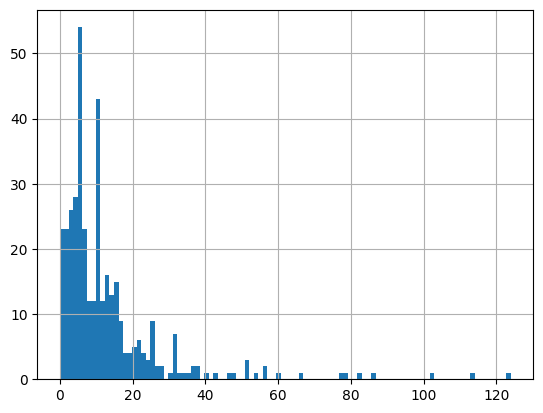

In [74]:
comments['word_count'].hist(bins=100)

In [75]:
comments['sym_count'].describe()

count    382.000000
mean     102.604712
std      124.485791
min        0.000000
25%       33.250000
50%       69.500000
75%      121.500000
max      959.000000
Name: sym_count, dtype: float64

<AxesSubplot: >

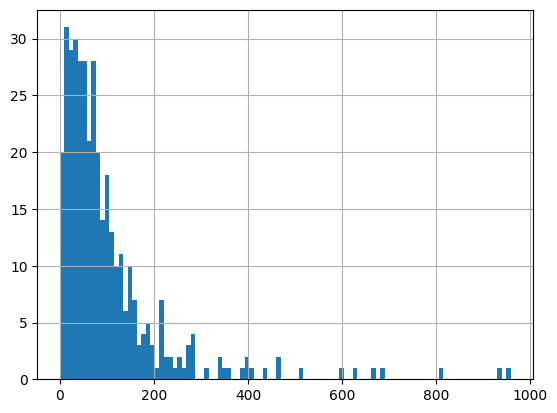

In [76]:
comments['sym_count'].hist(bins=100)

Большинство наблюдений не превышает 50 слов в комментариях
Большинство наблюдений не превышает 200 символов в комментариях

# Оценка токенов

In [89]:
from nltk import word_tokenize

all_text = [word_tokenize(line) for line in preprocessed_corpora]

In [90]:
from nltk import FreqDist


n_types = []
n_tokens = []
fd = FreqDist()
for line in all_text:
    fd.update(line)
    n_types.append(len(fd))
    n_tokens.append(sum(list(fd.values())))
for i in fd.most_common(10):
    print(i)

('это', 1145)
('косметика', 887)
('озон', 759)
('заказывать', 595)
('покупать', 515)
('видео', 505)
('спасибо', 503)
('очень', 479)
('весь', 462)
('оригинал', 456)


## Закон Ципфа
В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: f=a/r

f – частота типа, r – ранг типа, a – параметр, для славянских языков – около 0.07

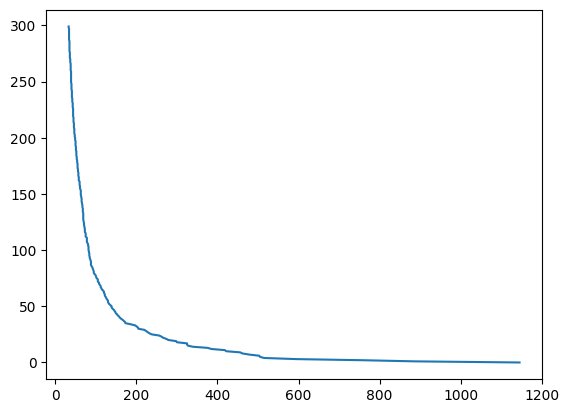

In [91]:
import matplotlib.pyplot as plt

freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

## Закон Хипса
С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: |V|=K∗N^b

N – число токенов, |V| – количество типов в словаре, K,b – параметры, обычно K∈[10,100],b∈[0.4,0.6]

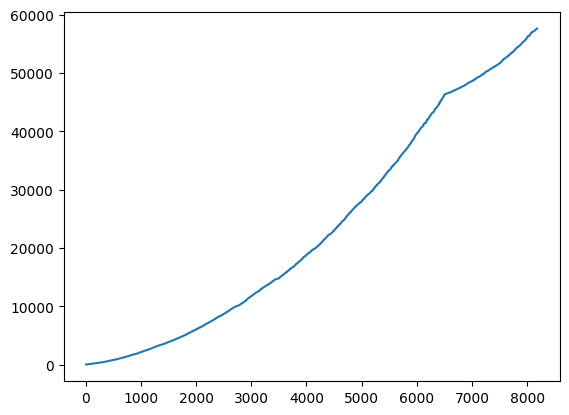

In [92]:
fig, ax = plt.subplots()
ax.plot(n_types, n_tokens)
plt.show()